In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from qibolab import create_platform, ExecutionParameters, AveragingMode, AcquisitionType
from qibolab.pulses import Pulse, ReadoutPulse, PulseSequence, Drag
from tqdm import tqdm

# Setting execution parameters
opts = ExecutionParameters(
    nshots=1000,  # Number of shots
    relaxation_time=200e3,  # Qubit relaxation time in ns
    acquisition_type=AcquisitionType.INTEGRATION,  # Type of acquisition
    averaging_mode=AveragingMode.SEQUENTIAL  # Averaging mode
)

# Creating platform and connecting
platform = create_platform("icarusq_rd_sq_a11")
platform.connect()

# Creating readout pulses for qubits 6 and 7
q6_ro = platform.create_qubit_readout_pulse(5, 0)
q7_ro = platform.create_qubit_readout_pulse(6, 0)

# Creating pi pulses for qubits 6 and 7
q6_pi_pulse = platform.create_RX_pulse(qubit=5, start=5)
q7_pi_pulse = platform.create_RX_pulse(qubit=6, start=5)
q7_drive_pulse = platform.create_qubit_drive_pulse(qubit=6, start=5, duration=5)
inverting_pulse = q7_drive_pulse
######################################################
# Q6 CRTL Q7 TARGET

# Creating control pulse
CR_pulse = q7_pi_pulse.copy()
CR_pulse.channel = q6_pi_pulse.channel

# Setting up pulse lengths for Rabi experiment
rabi_pulse_length = np.arange(0, 1000, 20)

# Setting up pulse lengths for Rabi experiment
rabi_pulse_length_part_1 = np.arange(0, 300, 20)
inverting_pulse_length = np.arange(300, 300+q7_pi_pulse.duration,20)
rabi_pulse_length_part_2 = np.arange(inverting_pulse_length[-1], 1010, 20)

total_length = np.append(rabi_pulse_length_part_1,inverting_pulse_length)
total_length = np.append(total_length,rabi_pulse_length_part_2)
# Initializing arrays for results
crtl_gnd_results = np.zeros(len(total_length))
crtl_exc_results = np.zeros(len(total_length))

Matplotlib created a temporary cache directory at /tmp/matplotlib-qv9c9zym because the default path (/home/atomics/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


[Qibo 0.2.3|INFO|2024-04-03 02:31:44]: Loading platform icarusq_rd_sq_a11
[Qibo 0.2.3|INFO|2024-04-03 02:31:44]: Connecting to instrument <qibolab.instruments.icarusqfpga.RFSOC_RO object at 0x7f1528ae5d50>.
[Qibo 0.2.3|INFO|2024-04-03 02:31:44]: Connected to board2, version: 2-1.8qbchip.0.0
[Qibo 0.2.3|INFO|2024-04-03 02:31:44]: Connecting to instrument <qibolab.instruments.icarusq.MCAttenuator object at 0x7f15286e82b0>.


In [2]:
# Creating pulse sequence for ground state
ps = PulseSequence(*[q6_pi_pulse, CR_pulse, q7_ro])
CR_pulse.start = q6_pi_pulse.finish
# Performing Rabi experiment for ground state
for idx, t in enumerate(tqdm(rabi_pulse_length_part_1)):
    CR_pulse.duration = t
    q7_ro.start = CR_pulse.finish
    crtl_exc_results[idx] = platform.execute_pulse_sequence(ps, opts)[q7_ro.serial].magnitude

# Creating pulse sequence for ground state
ps = PulseSequence(*[CR_pulse, inverting_pulse, q7_ro])
CR_pulse.duration = 300
for idx, t in enumerate(tqdm(inverting_pulse_length)):
    inverting_pulse.start = CR_pulse.finish
    inverting_pulse.duration = t - inverting_pulse_length[0]
    q7_ro.start = q7_pi_pulse.finish
    crtl_exc_results[idx+len(rabi_pulse_length_part_1)] = platform.execute_pulse_sequence(ps, opts)[q7_ro.serial].magnitude

# Creating pulse sequence for ground state
CR_pulse_2 = CR_pulse.copy()
ps = PulseSequence(*[CR_pulse, q7_pi_pulse, CR_pulse_2, q7_ro])

for idx, t in enumerate(tqdm(rabi_pulse_length_part_2)):
    q7_pi_pulse.start = CR_pulse.finish
    CR_pulse_2.start = q7_pi_pulse.finish
    CR_pulse_2.duration = t-rabi_pulse_length_part_2[0]
    q7_ro.start = CR_pulse_2.finish
    crtl_exc_results[idx+len(rabi_pulse_length_part_1)+len(inverting_pulse_length)] = platform.execute_pulse_sequence(ps, opts)[q7_ro.serial].magnitude


100%|██████████| 34/34 [00:14<00:00,  2.34it/s]


Text(0.5, 1.0, 'Rabi with X pulse on qubit 7 at t = 300 ns')

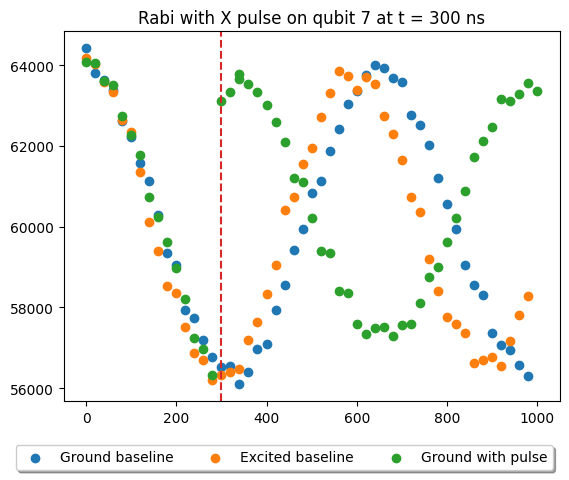

In [3]:
baseline_crtl_gnd_results = np.load('crtl_gnd_results.npy')
baseline_crtl_exc_results = np.load('crtl_exc_results.npy' )
rabi_pulse_length = np.load('rabi_pulse_length.npy' )

# Plotting results
plt.scatter(rabi_pulse_length, baseline_crtl_gnd_results, color="C0",label = 'Ground baseline')
plt.scatter(rabi_pulse_length, baseline_crtl_exc_results, color="C1",label = 'Excited baseline')
plt.scatter(total_length[crtl_exc_results>10], crtl_exc_results[crtl_exc_results>10], color="C3", label = 'Ground with pulse')

plt.axvline(300,linestyle = 'dashed', color = 'C3')
#plt.scatter(rabi_pulse_length, crtl_exc_results, color="orange")
plt.legend(bbox_to_anchor=(1, -0.1),shadow=True, ncol=3)
plt.savefig('rabi_exc_300.png')  # Saving plot as image file
plt.title("Rabi with X pulse on qubit 7 at t = 300 ns")